In [20]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
%matplotlib inline
import os
import sys

print (sys.stdout.encoding)

os.environ['E_FINMIND_USERID'] = 'funningboy'
os.environ['E_FINMIND_PASSWORD'] = 'qwer1234'

import requests
import pandas as pd
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanStockInfo",
    "token": "", # 參考登入，獲取金鑰
}
resp = requests.get(url, params=parameter)
data = resp.json()
data = pd.DataFrame(data["data"])

rename = {
    'stock_id': 'symbol',
    'stock_name': 'co_name',
    'type': 'exchange',
    'industry_category': 'industry'
}
data = data.rename(columns=rename)
#abu symbol frame
#,co_name,symbol,market,asset,co_site,amplitude,pe_s_d,co_intro,sc,prospectus,co_tel,exchange,co_addr,mv,equity,industry,turnover,oo,pb_MRQ

print(data)






UTF-8
     industry symbol  co_name exchange
0         ETF   0050   元大台灣50     twse
1         ETF   0051  元大中型100     twse
2         ETF   0052     富邦科技     twse
3         ETF   0053     元大電子     twse
4         ETF   0054   元大台商50     twse
...       ...    ...      ...      ...
2755     鋼鐵工業   9958      世紀鋼     twse
2756     貿易百貨   9960      邁達康     tpex
2757     鋼鐵工業   9962       有益     tpex
2758       大盤  TAIEX     加權指數     twse
2759       大盤   TPEx     櫃買指數     tpex

[2760 rows x 4 columns]


In [2]:
from bs4 import BeautifulSoup 
import requests
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [3]:
td = date.today().isoformat()
print (td)
lls = lambda x: [x]

2021-02-06


In [4]:
URL = 'http://fubon-ebrokerdj.fbs.com.tw/Z/ZC/ZCX/ZCX_2330.djhtm'

resp = requests.get(URL)
soup = BeautifulSoup(resp.text, 'html.parser')
table = soup.find_all('table', {'class': 't01'})[1]
values = list(map(lambda x: str(x.text).replace(',',''), table.find_all('td', {'class': 't3n1'})))
ohlcV = {
    'O': 0,
    'H': 1,
    'L': 2,
    'C': 3,
    'V': 11
}
for k,v in ohlcV.items():
    ohlcV[k] = lls(values[ohlcV[k]])
    
ohlcV = pd.DataFrame(ohlcV)
ohlcV

,O,H,L,C,V
0,638.00,641.00,631.00,632.00,61633


In [5]:
URL= 'http://fubon-ebrokerdj.fbs.com.tw/z/zc/zcx/zcxD5.djjs?A=2330'

resp = requests.get(URL)
soup = BeautifulSoup(resp.text, 'html.parser')
table = soup.find_all('table', {'class': 't01'})[0]
values = list(map(lambda x: str(x.text).replace(',',''), table.find_all('td', {'class': 't3n1'})))
print(values)
MarginPS = {
    'MarginPurchaseBuy': 0,
    'MarginPurchaseCashRepayment' : 2,
    'MarginPurchaseLimit': 4,
    'MarginPurchaseSell': 1,
    'MarginPurchaseTodayBalance': 3,
    'MarginPurchaseYesterdayBalance': 7
}
for k,v in MarginPS.items():
    MarginPS[k] = lls(values[MarginPS[k]])
    
MarginPS.update({
    'date': [td],
    'stock_id': ['2330']
})
data = pd.DataFrame(MarginPS)
data



['1603', '2059', '75', '32450', '6482595', '0.50%', '80', '80', '1', '903', '2.78%', '16', '1169', '1139', '361', '32981', '6482595', '0.51%', '68', '117', '1', '904', '2.74%', '9', '1363', '2409', '95', '33312', '6482595', '0.51%', '56', '78', '0', '954', '2.86%', '19', '3093', '5174', '190', '34453', '6482595', '0.53%', '206', '166', '0', '976', '2.83%', '45', '2614', '2742', '49', '36724', '6482595', '0.57%', '270', '109', '0', '936', '2.55%', '38']


,MarginPurchaseBuy,MarginPurchaseCashRepayment,MarginPurchaseLimit,MarginPurchaseSell,MarginPurchaseTodayBalance,MarginPurchaseYesterdayBalance,date,stock_id
0,1603,75,6482595,2059,32450,80,2021-02-06,2330


In [6]:
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanStockMarginPurchaseShortSale",
    "data_id": "2330",
    "start_date": td,
    "token": "", # 參考登入，獲取金鑰
}
data = requests.get(url, params=parameter)
data = data.json()
data = pd.DataFrame(data['data'])
data
#data.head()

""


In [7]:
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

NumExpr defaulting to 8 threads.


In [8]:
# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.disable_example_env_ipython()

disable example env


In [9]:
abupy.env.g_is_ipython = 0

In [10]:
abupy.env.g_data_fetch_mode

<EMarketDataFetchMode.E_DATA_FETCH_NORMAL: 0>

In [11]:
abupy.env.g_data_fetch_mode = abupy.EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET

In [12]:
abupy.ABuSymbolPd.make_kl_df('2330', n_folds=4).tail()

tw_TWSE:2330


,open,close,high,low,volume,date,pre_close,date_week,p_change,atr21,atr14,key
2021-02-01,595.0,611.0,612.0,587.0,68880939,20210201,591.0,0,3.384,25.0616,26.9786,981
2021-02-02,629.0,632.0,638.0,622.0,80724207,20210202,611.0,1,3.437,27.0560,29.6481,982
2021-02-03,638.0,630.0,642.0,630.0,49634227,20210203,632.0,2,-0.316,27.4145,29.8283,983
2021-02-04,626.0,627.0,632.0,620.0,47008873,20210204,630.0,3,-0.476,26.0132,27.4512,984
2021-02-05,638.0,632.0,641.0,631.0,54090831,20210205,627.0,4,0.797,24.6484,25.2577,985


In [13]:
from abupy import AbuDoubleMaBuy, AbuDoubleMaSell, AbuSDBreak, AbuFactorBuyBreak
from abupy import AbuFactorCloseAtrNStop, AbuFactorAtrNStop, AbuFactorPreAtrNStop
from abupy import abu, ABuProgress, AbuMetricsBase, EMarketTargetType, ABuMarketDrawing
from abupy import AbuFactorSellNDay, AbuFactorBuyWD, AbuFactorSellBreak
from abupy import AbuSymbolTW

In [14]:
buy_factors = [{'class': AbuDoubleMaBuy},
               {'xd': 21, 'class': AbuFactorBuyBreak}, 
               {'xd': 7, 'class': AbuSDBreak}]

sell_factors = [
    {'class': AbuDoubleMaSell},
    {'xd': 21, 'class': AbuFactorSellBreak},
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0, 'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

In [15]:
# 使用沙盒内的美股做为回测目标
choice_symbols = ['2330']

# 初始资金量
read_cash = 3000000
# 使用run_loop_back运行策略
abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   n_folds=6,
                                                   choice_symbols=choice_symbols)
ABuProgress.clear_output()

买入后卖出的交易数量:131
买入后尚未卖出的交易数量:0
胜率:52.6718%
平均获利期望:6.9064%
平均亏损期望:-2.9491%
盈亏比:2.5234
策略收益: 43.6574%
基准收益: 344.7553%
策略年化收益: 10.8549%
基准年化收益: 85.7191%
策略买入成交比例:97.7099%
策略资金利用率比例:21.9310%
策略共执行1468个交易日


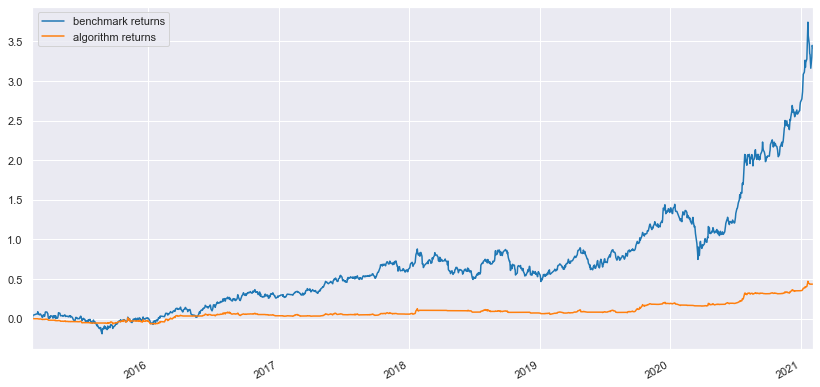

In [16]:
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

In [17]:
orders_pd = abu_result_tuple.orders_pd
view_orders = orders_pd[(orders_pd['symbol'] == '2330')]
view_orders

,buy_date,buy_price,buy_cnt,buy_factor,symbol,buy_pos,buy_type_str,expect_direction,sell_type_extra,sell_date,sell_price,sell_type,ml_features,key,profit,result,profit_cg,profit_cg_hunder,keep_days
2015-02-26,20150226,152.25,3000.0,AbuSDBreak:7,2330,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_loss=1.0,20150311,145.50,loss,None,7,-20250.0,-1,-0.0443,-4.4335,13
2015-03-18,20150318,152.00,3000.0,AbuSDBreak:7,2330,AbuAtrPosition,call,1.0,AbuFactorSellBreak:21,20150330,143.00,loss,None,20,-27000.0,-1,-0.0592,-5.9211,12
2015-04-13,20150413,146.75,4000.0,AbuSDBreak:7,2330,AbuAtrPosition,call,1.0,AbuFactorSellBreak:21,20150420,142.75,loss,None,36,-16000.0,-1,-0.0273,-2.7257,7
2015-04-24,20150424,150.50,3000.0,AbuSDBreak:7,2330,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_loss=1.0,20150522,146.00,loss,None,45,-13500.0,-1,-0.0299,-2.9900,28
2015-04-27,20150427,151.50,3000.0,AbuFactorBuyBreak:21,2330,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_loss=1.0,20150522,146.00,loss,None,46,-16500.0,-1,-0.0363,-3.6304,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-16,20201116,476.75,1000.0,AbuFactorBuyBreak:21,2330,AbuAtrPosition,call,1.0,AbuFactorCloseAtrNStop:close_atr_n=1.5,20201216,511.00,win,None,1409,34250.0,1,0.0718,7.1841,30
2020-11-17,20201117,495.75,1000.0,AbuSDBreak:7,2330,AbuAtrPosition,call,1.0,AbuFactorCloseAtrNStop:close_atr_n=1.5,20201216,511.00,win,None,1410,15250.0,1,0.0308,3.0761,29
2020-12-31,20201231,527.00,1000.0,AbuFactorBuyBreak:21,2330,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_win=3.0,20210122,657.00,win,None,1442,130000.0,1,0.2467,24.6679,22
2021-01-04,20210104,534.00,1000.0,AbuSDBreak:7,2330,AbuAtrPosition,call,1.0,AbuFactorCloseAtrNStop:close_atr_n=1.5,20210126,625.00,win,None,1443,91000.0,1,0.1704,17.0412,22


In [18]:
trade_df = ABuMarketDrawing.plot_candle_from_order(view_orders)

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

tw_TWSE:2330


No module named 'matplotlib.date'
Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 252, in _do_plot_candle
    import matplotlib.date as mdf
ModuleNotFoundError: No module named 'matplotlib.date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 92, in plot_from_series
    view_index=view_index_inner, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 133, in plot_candle_from_symbol
    plot_candle_form_klpd(kl_pd, day_sum, html_bk, view_index, save=save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 166, in plot_candle_form_klpd
    fn, day_sum, html_bk, save)
  File "D:\sean.chen\trader\abu\abupy\MarketBu\ABuMarketDrawing.py", line 188, in plot_candle_stick
    _do_plot_candle(date, p_open, high, low, close, volume, view_index, symbol, d

In [19]:

import 

SyntaxError: invalid syntax (<ipython-input-19-4cf4f10edf52>, line 1)